# Data Cleaning: Handling Missing values using Interpolation method:

## Description: Code for data identifying and replacing missing data
#### References:www.towardsdatascience.com ,
#### link: https://towardsdatascience.com/how-to-interpolate-time-series-data-in-apache-spark-and-python-pandas-part-1-pandas-cff54d76a2ea , https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779 .
### Author: Monika Dogra
### Revision:1
### Date: 19 Dec 2019

## Interpolation :
* The interpolation formula can be used to find the missing value. However, by drawing a straight line through two points on a curve, the value at other points on the curve can be approximated. In the formula for interpolation, x-sub1 and y-sub1 represent the first set of data points of the values observed.

* In scipy.interpolate is a convenient method to create a function based on fixed data points, which can be evaluated anywhere within the domain defined by the given data using linear interpolation. An instance of this class is created by passing the 1-D vectors comprising the data. The instance of this class defines a __call__ method and can therefore by treated like a function which interpolates between known data values to obtain unknown values (it also has a docstring for help). Behavior at the boundary can be specified at instantiation time.

## Import Libraries :

In [1]:


import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



First we generate a pandas data frame df0 with some test data. We create a data set containing two houses and use a $sin$ and a $cos$ function to generate some read data for a set of dates. To generate the missing values, we randomly drop half of the entries.

In [2]:
data = {'datetime': pd.date_range(start='1/15/2018', end='02/14/2018', freq='D')\
                .append(pd.date_range(start='1/15/2018', end='02/14/2018', freq='D')),
        'house' : ['house1' for i in range(31)] + ['house2' for i in range(31)],
        'readvalue':  [0.5 + 0.5*np.sin(2*np.pi/30*i) for i in range(31)]\
                    + [0.5 + 0.5*np.cos(2*np.pi/30*i) for i in range(31)]}
df0 = pd.DataFrame(data, columns = ['datetime', 'house', 'readvalue'])

# Randomly drop half the reads
random.seed(42)
df0 = df0.drop(random.sample(range(df0.shape[0]), k=int(df0.shape[0]/2)))

This is how the data looks like. A $sin$ and a $cos$ with plenty of missing data points.

/home/ritesh/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


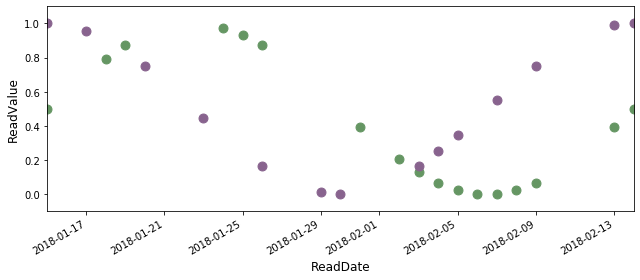

In [3]:
# Generating a plot of the data with missing values
# Setting figure properties
params = {'legend.fontsize' : 'large',
         'figure.figsize': (9,4),
         'axes.labelsize': 'large',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium'}
plt.rcParams.update(params)

# Generate colors using nices seaborn color palette
colors = {"house1": sns.color_palette("Set1", n_colors=8, desat=.5)[2],\
          "house2": sns.color_palette("Set1", n_colors=8, desat=.5)[3]}

fig, ax = plt.subplots()

for myhouse in ["house1", "house2"]:
    ax.scatter(pd.DatetimeIndex(df0[df0.house==myhouse]['datetime']),
               df0[df0.house==myhouse]['readvalue'],
               color=colors[myhouse],
               s=80)

ax.set_xlabel("ReadDate")
ax.set_ylabel("ReadValue")

# Format x-axis to properly displays dates
fig.autofmt_xdate()
ax.set_xlim(min(pd.DatetimeIndex(df0['datetime'])), max(pd.DatetimeIndex(df0['datetime'])))
ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.savefig('interpolating-timeseries-p1-pandas-fig1.png')
plt.show()



We will now look at three different methods of interpolating the missing read values: forward-filling, backward-filling and interpolating. Remember that it is crucial to choose the adequate interpolation method for the task at hand. Special care needs to be taken when looking at forecasting tasks (for example if you want to use your interpolated data for forecasting weather than you need to remember that you cannot interpolate the weather of today using the weather of tomorrow since it is still unknown).

In order to interpolate the data, we will make use of the groupby() function followed by resample(). However, first we need to convert the read dates to datetime format and set them as index of our dataframe:


In [4]:
df = df0.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
df.index = df['datetime']
del df['datetime']



This is how the structure of the dataframe looks like now:


In [11]:
df.head()

,house,readvalue
datetime,,
2018-01-15,house1,0.500000
2018-01-18,house1,0.793893
2018-01-19,house1,0.871572
2018-01-24,house1,0.975528
2018-01-25,house1,0.933013


In [12]:
df.shape

(31, 2)


## Interpolation:

Since we want to interpolate for each house separately, we need to group our data by 'house' before we can use the resample() function with the option 'D' to resample the data to daily frequency.

The next step is then to use mean-filling, forward-filling or backward-filling to determine how the newly generated grid is supposed to be filled.
### mean():

Since we are strictly upsampling, using the mean() method, all missing read values are filled with NaNs:


In [6]:
df.groupby('house').resample('D').mean().head(4)

readvalue
house  datetime             
house1 2018-01-15   0.500000
       2018-01-16        NaN
       2018-01-17        NaN
       2018-01-18   0.793893


### pad() - forward filling

Using .pad() instead of .mean() forward-fills the NaNs.


In [7]:
df_pad = df.groupby('house')\
            .resample('D')\
            .pad()\
            .drop('house', axis=1)
df_pad.head(4)

readvalue
house  datetime             
house1 2018-01-15   0.500000
       2018-01-16   0.500000
       2018-01-17   0.500000
       2018-01-18   0.793893


## bfill - backward filling:

Using .bfill() instead of .mean() backward-fills the NaNs:


In [8]:
df_bfill = df.groupby('house')\
            .resample('D')\
            .bfill()\
            .drop('house', axis=1)
df_bfill.head(4)

readvalue
house  datetime             
house1 2018-01-15   0.500000
       2018-01-16   0.793893
       2018-01-17   0.793893
       2018-01-18   0.793893

## interpolate() - interpolating

If we want to mean interpolate the missing values, we need to do this in two steps. First, we generate the data grid by using mean() to generate NaNs. Afterwards we fill the NaNs by interpolated values by calling the interpolate() method on the readvalue column:


In [9]:
df_interpol = df.groupby('house')\
                .resample('D')\
                .mean()
df_interpol['readvalue'] = df_interpol['readvalue'].interpolate()
df_interpol.head(4)

readvalue
house  datetime             
house1 2018-01-15   0.500000
       2018-01-16   0.597964
       2018-01-17   0.695928
       2018-01-18   0.793893

## Visualizing the Results

Finally we can visualize the three different filling methods to get a better idea of their results. The opaque dots show the interpolated values.

We can clearly see how in the top figure, the gaps have been filled with the last known value, in the middle figure, the gaps have been filled with the next value to come and in the bottom figure the difference has been interpolated.


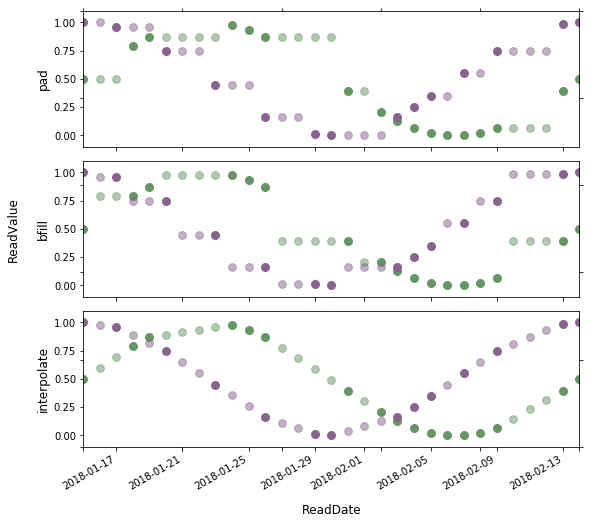

In [10]:
# Setting figure parameters
params = {'legend.fontsize' : 'large',
         'figure.figsize': (9,8),
         'axes.labelsize': 'large',
         'xtick.labelsize': 'medium',
         'ytick.labelsize': 'medium'}
plt.rcParams.update(params)

# Generate a list of dataframes to loop over
dfs = []
dfs.append(df_pad.reset_index())
dfs.append(df_bfill.reset_index())
dfs.append(df_interpol.reset_index())

ylabel = ['pad', 'bfill', 'interpolate']

n_df = len(dfs)
fig, ax = plt.subplots(n_df)

for myhouse in ["house1", "house2"]:

    for i in range(n_df):
        ax[i].scatter(pd.DatetimeIndex(dfs[i][dfs[i].house==myhouse]['datetime']), pd.to_numeric(dfs[i][dfs[i].house==myhouse]['readvalue']), color=colors[myhouse], s=60, alpha=0.5)
        ax[i].scatter(pd.DatetimeIndex(df0[df0.house==myhouse]['datetime']), pd.to_numeric(df0[df0.house==myhouse]['readvalue']), color=colors[myhouse], s=60)
        
        ax[i].set_xlim(min(pd.DatetimeIndex(df0['datetime'])), max(pd.DatetimeIndex(df0['datetime'])))
        ax[i].set_ylim([-0.1, 1.1])

fig.autofmt_xdate()

for i in range(n_df):
    ax[i].set_ylabel(ylabel[i])

# Adding another subplot in order to have common y-label
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the common axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('ReadDate', labelpad=40)
plt.ylabel('ReadValue', labelpad=40)

plt.tight_layout()
plt.savefig('interpolating-timeseries-p1-pandas-fig2.png')
plt.show()
plt.close()



# Summary:

* We have seen how we can use Python Pandas to interpolate time series data using either backfill, forward fill or interpolation methods. Having used this example to set the scene, in the next post, we will see how to achieve the same thing using PySpark.


* Pandas dataframe.interpolate() function is basically used to fill NA values in the dataframe or series. But, this is a very powerful function to fill the missing values. It uses various interpolation technique to fill the missing values rather than hard-coding the value.


* Syntax: DataFrame.interpolate(method=’linear’, axis=0, limit=None, inplace=False, limit_direction=’forward’, limit_area=None, downcast=None, **kwargs)

Parameters :
method : {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’}

axis : 0 fill column-by-column and 1 fill row-by-row.

limit : Maximum number of consecutive NaNs to fill. Must be greater than 0.

limit_direction : {‘forward’, ‘backward’, ‘both’}, default ‘forward’

limit_area : None (default) no fill restriction. inside Only fill NaNs surrounded by valid values (interpolate). outside Only fill NaNs outside valid values (extrapolate). If limit is specified, consecutive NaNs will be filled in this direction.

inplace : Update the NDFrame in place if possible.

downcast : Downcast dtypes if possible.

kwargs : keyword arguments to pass on to the interpolating function.

Returns : Series or DataFrame of same shape interpolated at the NaNs 